## Import libraries and dataset

In [286]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# preprocessing + feature engineering tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from feature_engine.encoding import OneHotEncoder, WoEEncoder, CountFrequencyEncoder

# models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier

%matplotlib inline

In [287]:
train = pd.read_csv('data/train.csv', delimiter=';')
test = pd.read_csv('data/test.csv', delimiter=';')

train.head()


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,100,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,101,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,102,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,103,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,104,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0


In [288]:
train.drop('id', axis=1, inplace=True)

test2 = test.copy()
test.drop('id', axis=1, inplace=True)

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  pdays      40000 non-null  int64 
 14  previous   40000 non-null  int64 
 15  poutcome   40000 non-null  object
 16  y          40000 non-null  int64 
dtypes: int64(8), object(9)
memory usage: 5.2+ MB


In [289]:
def check_data(df):
    missing_values = df.isnull().sum()

    print(f"There are {missing_values.sum()} missing values")
    if missing_values.sum() > 0:
        print(df.isnull().sum())

    print(f"There are {df.duplicated().sum()} duplicated values")

check_data(train)


There are 0 missing values
There are 0 duplicated values


In [290]:
check_data(test)

There are 0 missing values
There are 0 duplicated values


No need to handle missing & duplicated data 

## Feature Engineering

### 📌 **Plan**:
- **Date Features** (`day`, `month`):
    - Convert into consistent numerical format, for example: January is the first month of the year so January = 1, February 2, and so on..
    - Transform into cyclical encoding:
        - Day_Sin
        - Day_Cos
        - Month_Sin
        - Month_Cos
- **Handle High Cardinality Categorical Features**
- **Categorical Encoding**:
    - Low Cardinality = OneHotEncoder k-1
    - High Cardinality = TargetEncoder, Count/Frequency Encoding
    - Multivariate Encoding for linearity, if the model used is linear based model
- **Feature Scaling (Numerical features only!)**:
    - Standardization: if the feature is gaussian distributed, otherwise
    - MinMaxScaler: if the feature is not gaussian distributed
- **Discretization?**

In [291]:
train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0


In [292]:
cat_cols = [var for var in train.columns if train[var].dtype == 'object']
num_cols = [var for var in train.columns if train[var].dtype != 'object']


cat_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [293]:
num_cols

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'y']

In [294]:
train['y'].value_counts()


y
0    37104
1     2896
Name: count, dtype: int64

Take a look at the target value distribution

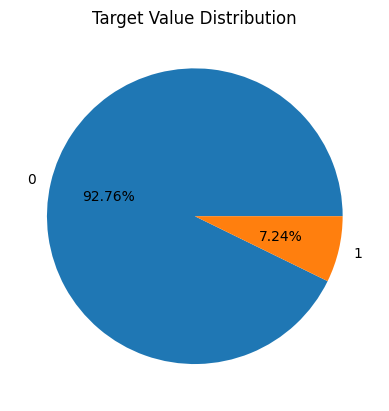

In [295]:
plt.pie(train['y'].value_counts(), autopct='%1.2f%%', labels=['0', '1'])
plt.title('Target Value Distribution')
plt.show()

Date Features Engineering

In [296]:
train['month'].unique()

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'jan', 'feb',
       'mar', 'apr'], dtype=object)

In [297]:
def month_to_number(month):
    if month == 'jan':
        return 1
    elif month == 'feb':
        return 2
    elif month == 'mar':
        return 3
    elif month == 'apr':
        return 4
    elif month == 'may':
        return 5
    elif month == 'jun':
        return 6
    elif month == 'jul':
        return 7
    elif month == 'aug':
        return 8
    elif month == 'sep':
        return 9
    elif month == 'oct':
        return 10
    elif month == 'nov':
        return 11
    elif month == 'dec':
        return 12

train['month'] = train['month'].apply(month_to_number)
test['month'] = test['month'].apply(month_to_number)

train['month'].value_counts()

month
5     13532
7      6380
8      5215
6      4734
11     3598
4      2718
2      2296
1      1176
3       258
10       80
12       13
Name: count, dtype: int64

In [298]:
test['month'].unique()

array([ 6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5])

In [299]:
train['day'].unique()

array([ 5,  6,  7,  8,  9, 12, 13, 14, 15, 16, 19, 20, 21, 23, 26, 27, 28,
       29, 30,  2,  3,  4, 11, 17, 18, 24, 25,  1, 10, 22, 31])

There's no `year` column, so let's assume year is 2024

In [300]:
train['year'] = 2024
test['year'] = 2024

# make a new column for date
train['date'] = pd.to_datetime(train[['year', 'month', 'day']])
test['date'] = pd.to_datetime(test[['year', 'month', 'day']])

train['date'].value_counts()
test['date'].value_counts()

date
2024-08-12    120
2024-08-13    105
2024-08-11     82
2024-06-04     77
2024-06-05     71
             ... 
2024-12-31      1
2024-02-21      1
2024-01-22      1
2024-04-17      1
2024-05-15      1
Name: count, Length: 271, dtype: int64

In [301]:
train.sample(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,year,date
24122,26,technician,single,tertiary,no,172,no,yes,telephone,4,11,21,1,140,4,other,0,2024,2024-11-04
1480,43,technician,married,secondary,no,1824,yes,no,unknown,8,5,296,1,-1,0,unknown,0,2024,2024-05-08
5608,36,blue-collar,married,primary,no,111,yes,no,unknown,23,5,163,3,-1,0,unknown,0,2024,2024-05-23
28737,27,unemployed,single,tertiary,no,3060,no,no,cellular,30,1,533,1,-1,0,unknown,0,2024,2024-01-30
25931,59,management,married,primary,no,2769,yes,no,cellular,19,11,104,1,131,2,failure,0,2024,2024-11-19


Cyclical Encoding

In [302]:
train['month_sin'] = np.sin(train['month'] /
                            train['month'].max() * 2 * np.pi)

train['month_cos'] = np.cos(train['month'] /
                            train['month'].max() * 2 * np.pi)

test['month_sin'] = np.sin(test['month'] /
                            test['month'].max() * 2 * np.pi)

test['month_cos'] = np.cos(test['month'] /
                            test['month'].max() * 2 * np.pi)

train.sample(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,...,duration,campaign,pdays,previous,poutcome,y,year,date,month_sin,month_cos
29001,51,technician,married,secondary,no,1490,yes,no,cellular,2,...,177,1,199,2,failure,0,2024,2024-02-02,0.866025,0.500000
30764,46,unemployed,married,primary,no,1251,yes,no,cellular,6,...,665,2,-1,0,unknown,0,2024,2024-02-06,0.866025,0.500000
5978,45,management,divorced,tertiary,no,-901,yes,no,unknown,26,...,86,3,-1,0,unknown,0,2024,2024-05-26,0.500000,-0.866025
15802,35,entrepreneur,single,secondary,no,475,no,yes,cellular,21,...,936,4,-1,0,unknown,0,2024,2024-07-21,-0.500000,-0.866025
25530,40,management,married,tertiary,no,12409,yes,no,cellular,19,...,140,1,99,2,failure,0,2024,2024-11-19,-0.500000,0.866025


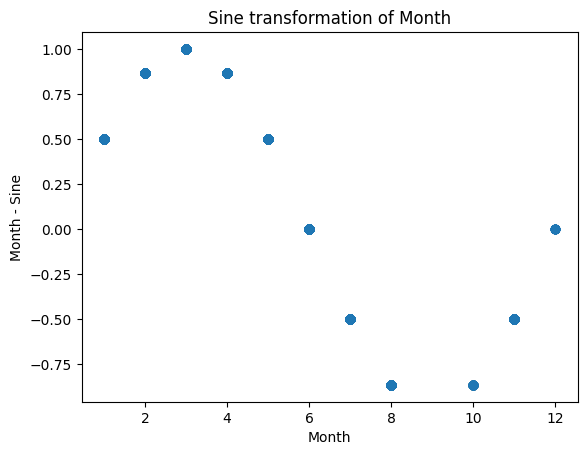

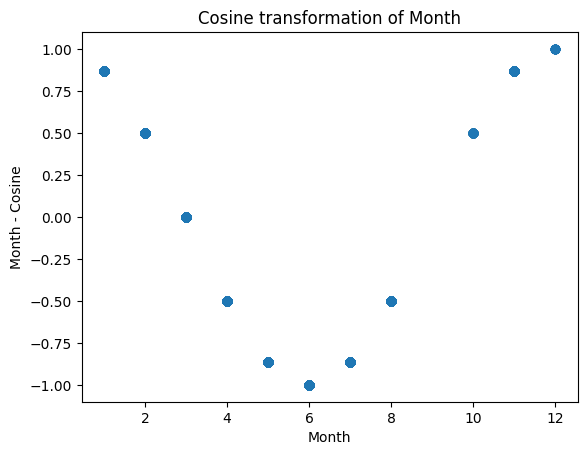

In [303]:
plt.scatter(train['month'], train['month_sin'])

plt.xlabel('Month')
plt.ylabel('Month - Sine')
plt.title('Sine transformation of Month')
plt.show()


plt.scatter(train['month'], train['month_cos'])

plt.xlabel('Month')
plt.ylabel('Month - Cosine')
plt.title('Cosine transformation of Month')
plt.show()

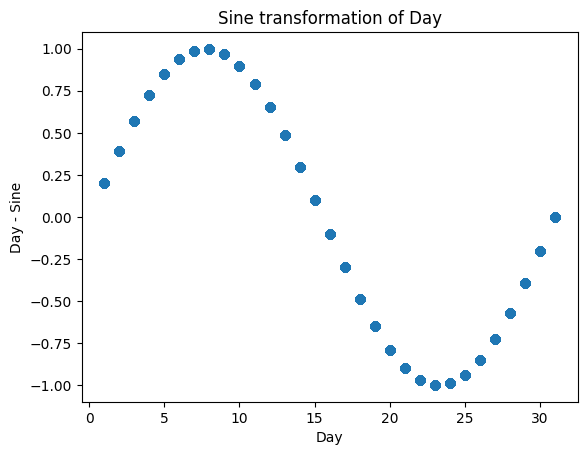

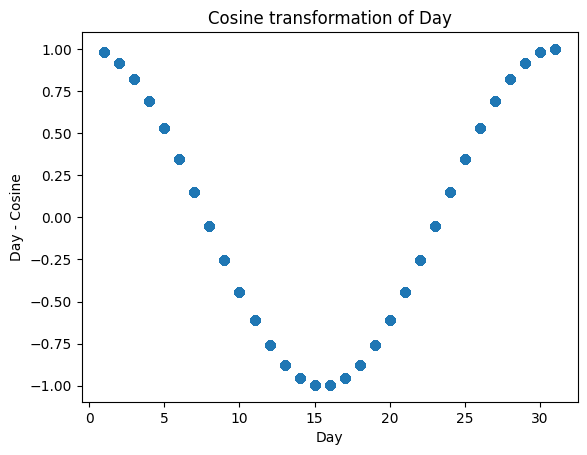

In [304]:
train['day_sin'] = np.sin(train['day'] /
                            train['day'].max() * 2 * np.pi)


train['day_cos'] = np.cos(train['day'] /
                            train['day'].max() * 2 * np.pi)

test['day_sin'] = np.sin(test['day'] /
                            test['day'].max() * 2 * np.pi)

test['day_cos'] = np.cos(test['day'] /
                            test['day'].max() * 2 * np.pi)


plt.scatter(train['day'], train['day_sin'])

plt.xlabel('Day')
plt.ylabel('Day - Sine')

plt.title('Sine transformation of Day')
plt.show()



plt.scatter(train['day'], train['day_cos'])

plt.xlabel('Day')
plt.ylabel('Day - Cosine')
plt.title('Cosine transformation of Day')
plt.show()

In [305]:
# make y to the last column position
y = train.pop('y')
train['y'] = y

train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,pdays,previous,poutcome,year,date,month_sin,month_cos,day_sin,day_cos,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,...,-1,0,unknown,2024,2024-05-05,0.5,-0.866025,0.848644,0.528964,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,...,-1,0,unknown,2024,2024-05-05,0.5,-0.866025,0.848644,0.528964,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,...,-1,0,unknown,2024,2024-05-05,0.5,-0.866025,0.848644,0.528964,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,...,-1,0,unknown,2024,2024-05-05,0.5,-0.866025,0.848644,0.528964,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,...,-1,0,unknown,2024,2024-05-05,0.5,-0.866025,0.848644,0.528964,0


In [306]:
train.drop('date', axis=1, inplace=True)
test.drop('date', axis=1, inplace=True)

### Categorical Columns

In [307]:
cat_cols = [var for var in train.columns if train[var].dtype == 'object']
num_cols = [var for var in train.columns if train[var].dtype != 'object']


cat_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'poutcome']

In [308]:
num_cols

['age',
 'balance',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'year',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'y']

In [309]:
for col in cat_cols:
    print(train[col].value_counts())
    print('-'*50)


job
blue-collar      9383
management       8166
technician       6852
admin.           4483
services         3910
retired          1437
self-employed    1414
entrepreneur     1405
unemployed       1104
housemaid        1087
student           524
unknown           235
Name: count, dtype: int64
--------------------------------------------------
marital
married     24386
single      10889
divorced     4725
Name: count, dtype: int64
--------------------------------------------------
education
secondary    20993
tertiary     11206
primary       6270
unknown       1531
Name: count, dtype: int64
--------------------------------------------------
default
no     39191
yes      809
Name: count, dtype: int64
--------------------------------------------------
housing
yes    24031
no     15969
Name: count, dtype: int64
--------------------------------------------------
loan
no     33070
yes     6930
Name: count, dtype: int64
--------------------------------------------------
contact
cellular     24

Assumption:
- `job`: TargetEncoder or WoE Encoding
- `marital`:
    - OneHotEncoder k-1
    - Combine Divorced with Single?
- Other: OneHotEncoder k-1


Try with other encoding method, maybe there's something that'll work?

In [310]:
train

,age,job,marital,education,default,balance,housing,loan,contact,day,...,campaign,pdays,previous,poutcome,year,month_sin,month_cos,day_sin,day_cos,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,...,1,-1,0,unknown,2024,5.000000e-01,-0.866025,0.848644,0.528964,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,...,1,-1,0,unknown,2024,5.000000e-01,-0.866025,0.848644,0.528964,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,...,1,-1,0,unknown,2024,5.000000e-01,-0.866025,0.848644,0.528964,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,...,1,-1,0,unknown,2024,5.000000e-01,-0.866025,0.848644,0.528964,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,...,1,-1,0,unknown,2024,5.000000e-01,-0.866025,0.848644,0.528964,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,technician,married,tertiary,no,395,no,no,cellular,3,...,1,-1,0,unknown,2024,1.224647e-16,-1.000000,0.571268,0.820763,0
39996,30,management,single,tertiary,no,3340,no,no,cellular,3,...,3,-1,0,unknown,2024,1.224647e-16,-1.000000,0.571268,0.820763,1
39997,54,admin.,divorced,secondary,no,200,no,no,cellular,3,...,1,-1,0,unknown,2024,1.224647e-16,-1.000000,0.571268,0.820763,1
39998,34,management,married,tertiary,no,1047,no,no,cellular,3,...,1,90,7,other,2024,1.224647e-16,-1.000000,0.571268,0.820763,0


In [311]:
train.drop('y', axis=1, inplace=True)

train.shape, test.shape

((40000, 21), (5211, 21))

OneHotEncoding k-1

In [312]:
ohe = OneHotEncoder(
    variables=['poutcome', 'contact', 'loan', 'housing', 'default', 'education', 'marital'],
    drop_last=True,
    drop_last_binary=True
)

train = ohe.fit_transform(train)
test = ohe.transform(test)


train['y'] = y
train.head()

,age,job,balance,day,month,duration,campaign,pdays,previous,year,...,contact_cellular,loan_no,housing_yes,default_no,education_tertiary,education_secondary,education_unknown,marital_married,marital_single,y
0,58,management,2143,5,5,261,1,-1,0,2024,...,0,1,1,1,1,0,0,1,0,0
1,44,technician,29,5,5,151,1,-1,0,2024,...,0,1,1,1,0,1,0,0,1,0
2,33,entrepreneur,2,5,5,76,1,-1,0,2024,...,0,0,1,1,0,1,0,1,0,0
3,47,blue-collar,1506,5,5,92,1,-1,0,2024,...,0,1,1,1,0,0,1,1,0,0
4,33,unknown,1,5,5,198,1,-1,0,2024,...,0,1,0,1,0,0,1,0,1,0


In [313]:
test.head()

,age,job,balance,day,month,duration,campaign,pdays,previous,year,...,contact_unknown,contact_cellular,loan_no,housing_yes,default_no,education_tertiary,education_secondary,education_unknown,marital_married,marital_single
0,57,retired,718,3,6,170,1,-1,0,2024,...,0,1,1,0,1,0,1,0,1,0
1,50,management,268,3,6,74,2,90,2,2024,...,0,1,1,0,1,0,1,0,1,0
2,46,technician,4367,3,6,65,1,96,1,2024,...,0,1,1,1,1,0,1,0,0,1
3,56,admin.,3554,3,6,151,1,-1,0,2024,...,0,1,1,0,1,0,1,0,1,0
4,32,services,785,3,6,273,1,-1,0,2024,...,0,1,1,0,1,1,0,0,0,1


In [314]:
train.shape, test.shape


((40000, 28), (5211, 27))

In [315]:
woe = WoEEncoder(variables=['job'])

train_features = train.drop('y', axis=1)
y = train['y']

train = woe.fit_transform(train_features, y)
test = woe.transform(test)

train['y'] = y

train.head()

,age,job,balance,day,month,duration,campaign,pdays,previous,year,...,contact_cellular,loan_no,housing_yes,default_no,education_tertiary,education_secondary,education_unknown,marital_married,marital_single,y
0,58,0.145263,2143,5,5,261,1,-1,0,2024,...,0,1,1,1,1,0,0,1,0,0
1,44,0.001987,29,5,5,151,1,-1,0,2024,...,0,1,1,1,0,1,0,0,1,0
2,33,-0.155381,2,5,5,76,1,-1,0,2024,...,0,0,1,1,0,1,0,1,0,0
3,47,-0.255286,1506,5,5,92,1,-1,0,2024,...,0,1,1,1,0,0,1,1,0,0
4,33,-0.000887,1,5,5,198,1,-1,0,2024,...,0,1,0,1,0,0,1,0,1,0


In [316]:
test.head()

,age,job,balance,day,month,duration,campaign,pdays,previous,year,...,contact_unknown,contact_cellular,loan_no,housing_yes,default_no,education_tertiary,education_secondary,education_unknown,marital_married,marital_single
0,57,0.408382,718,3,6,170,1,-1,0,2024,...,0,1,1,0,1,0,1,0,1,0
1,50,0.145263,268,3,6,74,2,90,2,2024,...,0,1,1,0,1,0,1,0,1,0
2,46,0.001987,4367,3,6,65,1,96,1,2024,...,0,1,1,1,1,0,1,0,0,1
3,56,0.084664,3554,3,6,151,1,-1,0,2024,...,0,1,1,0,1,0,1,0,1,0
4,32,-0.185827,785,3,6,273,1,-1,0,2024,...,0,1,1,0,1,1,0,0,0,1


### Numerical Columns

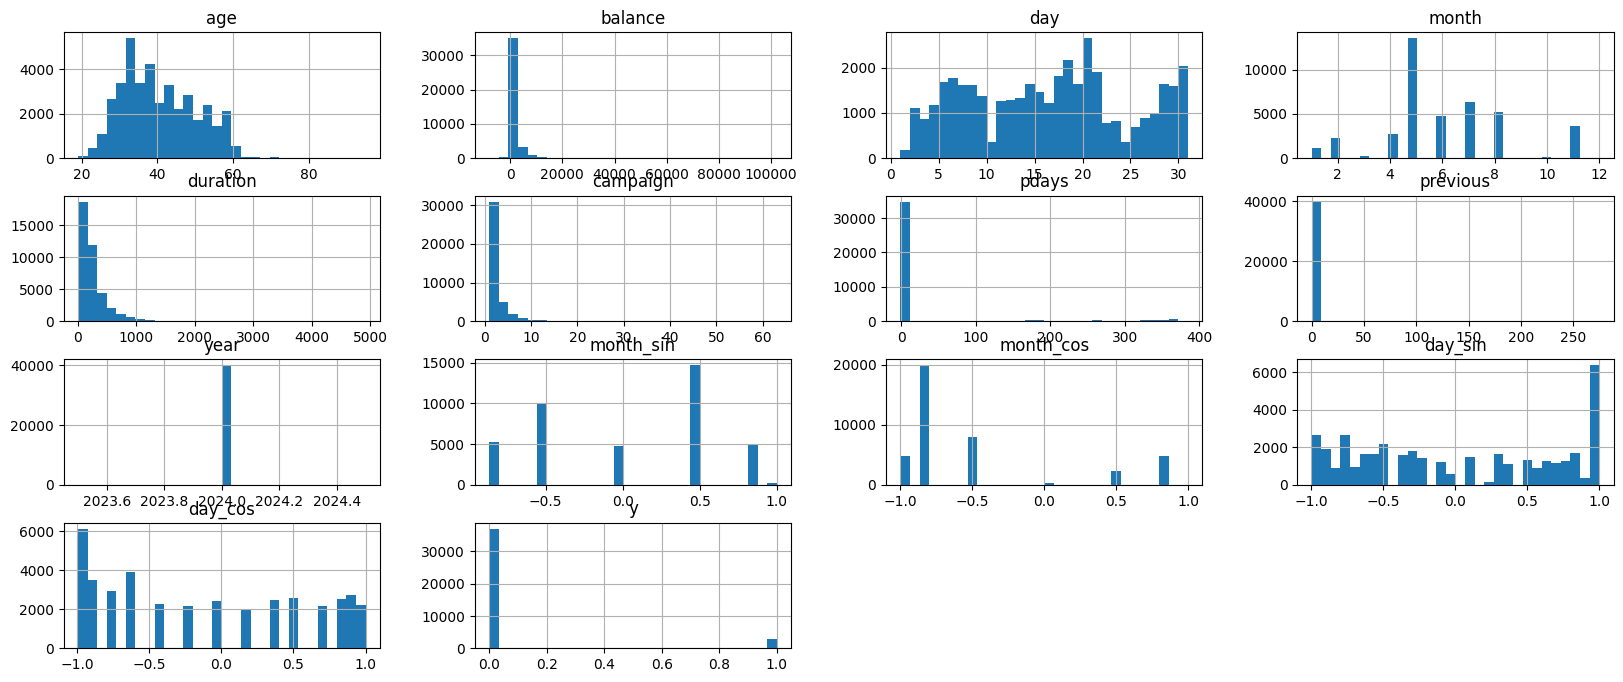

In [317]:
train[num_cols].hist(bins=30, figsize=(20, 8));

Year column is useless

In [318]:
train.drop('year', axis=1, inplace=True)
test.drop('year', axis=1, inplace=True)

### Variable Transforming Experiment

We can try log-transforming the duration column to make it more symmetrical

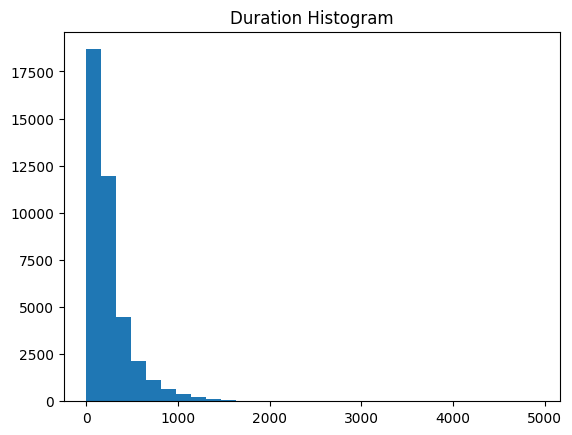

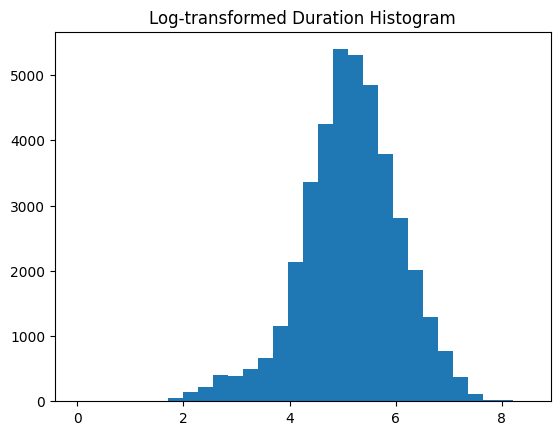

In [319]:
plt.hist(train['duration'], bins=30);
plt.title('Duration Histogram');
plt.show()

train['duration'] = np.log1p(train['duration'])
test['duration'] = np.log1p(test['duration'])


plt.hist(train['duration'], bins=30);

plt.title('Log-transformed Duration Histogram');
plt.show()

Might compare performance with or without log transformation

In [320]:
train['pdays'].replace(-1, np.nan, inplace=True)
test['pdays'].replace(-1, np.nan, inplace=True)

train['pdays'].isnull().sum()

np.int64(34607)

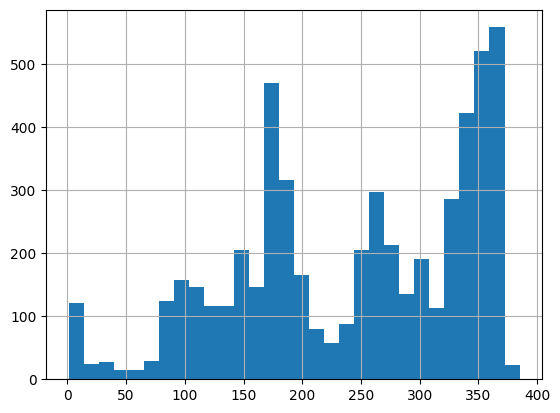

In [321]:
train['pdays'].hist(bins=30);

Handling `Pdays` column:
- Best Option: Leave NaN as is (let the model handle it).
- Alternative: Apply discretization binning and convert NaN to "Never_contacted" category.

In [322]:
# remove year from list
num_cols.remove('year')


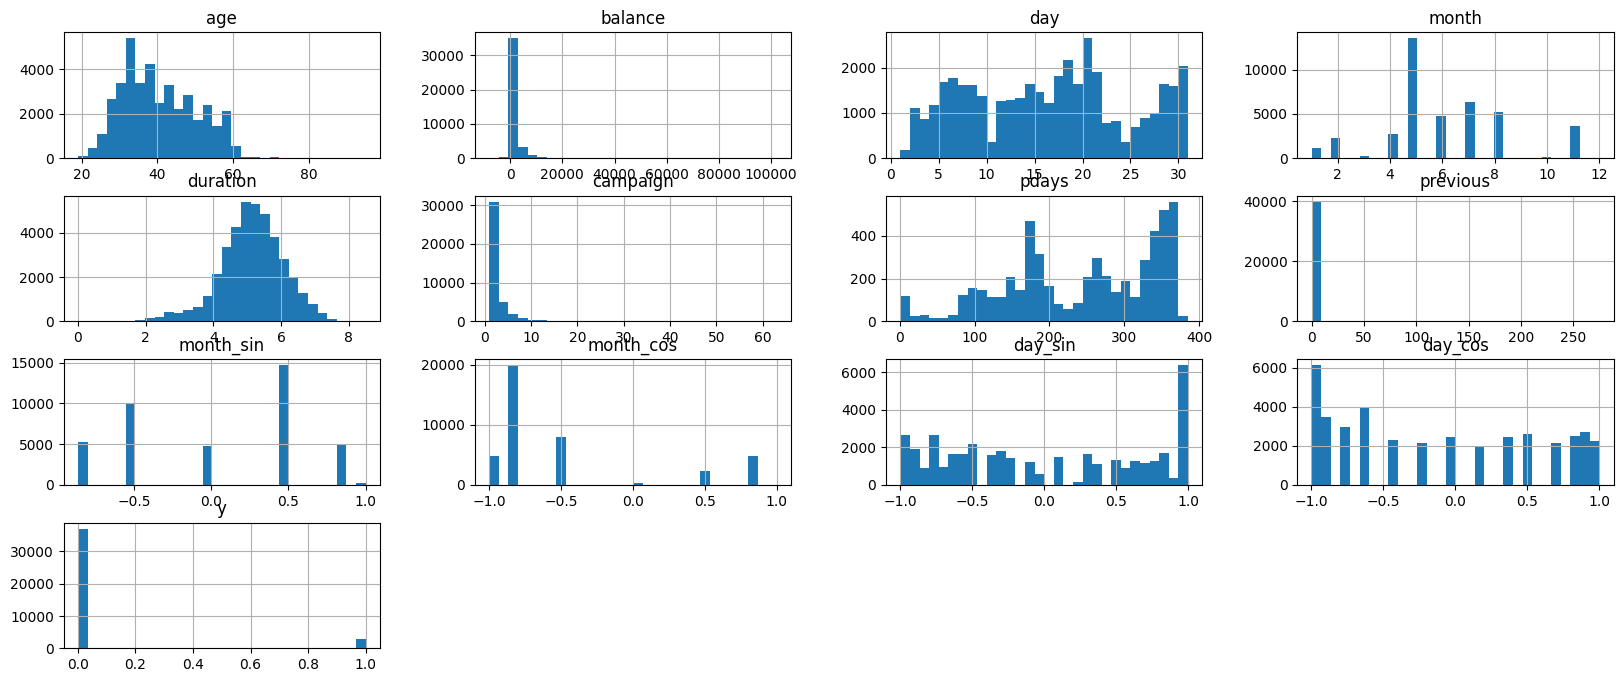

In [323]:
train[num_cols].hist(bins=30, figsize=(20, 8));

Might compare performance with or without feature scaling

In [324]:
# drop day and month columns
train.drop(['day', 'month'], axis=1, inplace=True)
test.drop(['day', 'month'], axis=1, inplace=True)

In [325]:
train.head()

,age,job,balance,duration,campaign,pdays,previous,month_sin,month_cos,day_sin,...,contact_cellular,loan_no,housing_yes,default_no,education_tertiary,education_secondary,education_unknown,marital_married,marital_single,y
0,58,0.145263,2143,5.568345,1,NaN,0,0.5,-0.866025,0.848644,...,0,1,1,1,1,0,0,1,0,0
1,44,0.001987,29,5.023881,1,NaN,0,0.5,-0.866025,0.848644,...,0,1,1,1,0,1,0,0,1,0
2,33,-0.155381,2,4.343805,1,NaN,0,0.5,-0.866025,0.848644,...,0,0,1,1,0,1,0,1,0,0
3,47,-0.255286,1506,4.532599,1,NaN,0,0.5,-0.866025,0.848644,...,0,1,1,1,0,0,1,1,0,0
4,33,-0.000887,1,5.293305,1,NaN,0,0.5,-0.866025,0.848644,...,0,1,0,1,0,0,1,0,1,0


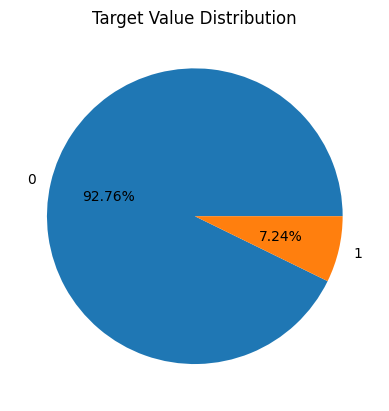

In [326]:
plt.pie(train['y'].value_counts(), autopct='%1.2f%%', labels=['0', '1'])
plt.title('Target Value Distribution')
plt.show()

### Apply Undersampling

In [327]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
X_res, y_res = rus.fit_resample(train.drop('y', axis=1), train['y'])

X_res.shape, y_res.shape


((5792, 24), (5792,))

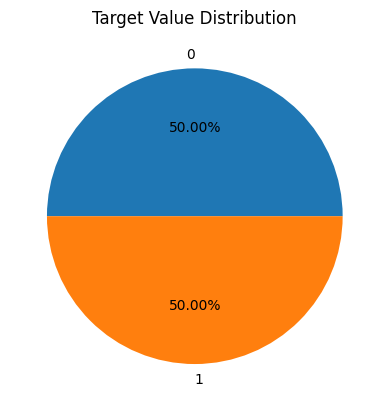

In [328]:
plt.pie(y_res.value_counts(), autopct='%1.2f%%', labels=['0', '1'])
plt.title('Target Value Distribution')
plt.show()


## Modelling

In [329]:
# Split data into train and validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_res,
    y_res,
    test_size=0.2,
    random_state=42
)


X_train.shape, X_val.shape, y_train.shape, y_val.shape

((4633, 24), (1159, 24), (4633,), (1159,))

In [330]:
# random forest
rf = RandomForestClassifier(n_estimators=200, random_state=0, class_weight='balanced')
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)

f1_score(y_val, y_pred)

0.8921232876712328

In [331]:
# xgboost
xgb = XGBClassifier(n_estimators=100, random_state=0, class_weight='balanced')
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_val)

f1_score(y_val, y_pred)


0.8954191875540191

In [332]:
# lgbm
lgbm = LGBMClassifier(n_estimators=200, random_state=0, class_weight='balanced')
lgbm.fit(X_train, y_train)

y_pred = lgbm.predict(X_val)

f1_score(y_val, y_pred)

[LightGBM] [Info] Number of positive: 2333, number of negative: 2300
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 877
[LightGBM] [Info] Number of data points in the train set: 4633, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


0.8957795004306632

## Predict on Test set

In [333]:
test_pred = lgbm.predict(test)

test_pred

test['y'] = test_pred

test.head()


,age,job,balance,duration,campaign,pdays,previous,month_sin,month_cos,day_sin,...,contact_cellular,loan_no,housing_yes,default_no,education_tertiary,education_secondary,education_unknown,marital_married,marital_single,y
0,57,0.408382,718,5.141664,1,NaN,0,1.224647e-16,-1.0,0.571268,...,1,1,0,1,0,1,0,1,0,1
1,50,0.145263,268,4.317488,2,90.0,2,1.224647e-16,-1.0,0.571268,...,1,1,0,1,0,1,0,1,0,1
2,46,0.001987,4367,4.189655,1,96.0,1,1.224647e-16,-1.0,0.571268,...,1,1,1,1,0,1,0,0,1,1
3,56,0.084664,3554,5.023881,1,NaN,0,1.224647e-16,-1.0,0.571268,...,1,1,0,1,0,1,0,1,0,1
4,32,-0.185827,785,5.613128,1,NaN,0,1.224647e-16,-1.0,0.571268,...,1,1,0,1,1,0,0,0,1,1


In [334]:
test['y'].value_counts()


y
1    2827
0    2384
Name: count, dtype: int64

In [335]:
test2 = test2[['id']]
test2

,id
0,40100
1,40101
2,40102
3,40103
4,40104
...,...
5206,45306
5207,45307
5208,45308
5209,45309


In [338]:
test2['y'] = test_pred

test2.head()


,id,y
0,40100,1
1,40101,1
2,40102,1
3,40103,1
4,40104,1


In [340]:
test2['y'].value_counts()

y
1    2827
0    2384
Name: count, dtype: int64

In [341]:
test2.to_csv('submission/raw-submission.csv', index=False)